## Frequency of Events in Distance Category
Author: Ru Feng, Anqi Wang and Jenny Empawi

#### Load libraries

In [10]:
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(showtext)
font_add_google("Noto Sans", "Noto Sans")
showtext_auto()

#### Load and prepare data

In [11]:
top_loci_integrated_distance_summary <- readRDS("/data/interactive_analysis/aw3600/Figure_codes/data/Figure_S1_P1.rds") # path in cloud

singlecontext_top_loci_table_integrated_distance_filtered_category <- top_loci_integrated_distance_summary %>% 
                                                                      filter(cs_coverage_0.95!=0) %>%
                                                                      mutate(distance_category = case_when(distance < 10e3 ~ "<10Kb",
                                                                                                           distance >= 10e3 & distance < 50e3 ~ "10Kb~50Kb",
                                                                                                           distance >= 50e3 & distance < 100e3 ~ "50Kb~100Kb",
                                                                                                           distance >= 100e3 & distance < 1e6 ~ "100Kb~1Mb",
                                                                                                           distance >= 1e6 ~ ">1Mb"),
                                                                       distance_category = factor(distance_category, levels = c("<10Kb", "10Kb~50Kb", "50Kb~100Kb", "100Kb~1Mb", ">1Mb")))

# Group by context and distance category, then calculate frequency
singlecontext_top_loci_table_integrated_distance_filtered_category <- singlecontext_top_loci_table_integrated_distance_filtered_category %>%
                                                                      group_by(resource, distance_category) %>%
                                                                      summarise(count = n(), .groups = "drop") %>%
                                                                      group_by(resource) %>%
                                                                      mutate(frequency = count / sum(count))

# Define the order of categories for the x-axis
singlecontext_top_loci_table_integrated_distance_filtered_category$context <- factor(singlecontext_top_loci_table_integrated_distance_filtered_category$resource, levels = unique(singlecontext_top_loci_table_integrated_distance_filtered_category$resource))

head(singlecontext_top_loci_table_integrated_distance_filtered_category)

resource,distance_category,count,frequency,context
<chr>,<fct>,<int>,<dbl>,<fct>
AC_DeJager_eQTL,<10Kb,4404,0.42728243,AC_DeJager_eQTL
AC_DeJager_eQTL,10Kb~50Kb,3628,0.35199379,AC_DeJager_eQTL
AC_DeJager_eQTL,50Kb~100Kb,1040,0.10090230,AC_DeJager_eQTL
AC_DeJager_eQTL,100Kb~1Mb,1050,0.10187251,AC_DeJager_eQTL
AC_DeJager_eQTL,>1Mb,185,0.01794897,AC_DeJager_eQTL
Ast_10_Kellis_eQTL,<10Kb,25,0.03434066,Ast_10_Kellis_eQTL


In [12]:
singlecontext_top_loci_table_integrated_distance_filtered_category <- singlecontext_top_loci_table_integrated_distance_filtered_category %>%
  mutate(
    # First rename the resources
    resource = case_when(
      grepl("DeJager", resource) ~ gsub("DeJager", "CUIMC1", resource),
      grepl("Kellis", resource) ~ gsub("Kellis", "MIT", resource),
      TRUE ~ resource
    ),
    # Then apply tissue grouping
    tissue_group = case_when(
      grepl("STARNET|ROSMAP|PCC|DLPFC|MSBB|Knight.*eQTL.*brain|AC.*CUIMC1|BM.*MSBB|PCC.*CUIMC1", resource) ~ "Bulk Brain Tissue",
      grepl("Inh|Exc", resource) ~ "Neurons",
      grepl("Knight.*pQTL|DLPFC.*Klein", resource) ~ "Other Modalities",
      grepl("MIGA|MiGA", resource) ~ "MiGA",
      grepl("Metabrain", resource) ~ "MetaBrain \nConsortium",
      TRUE ~ "Glia"
    )
  )


# Create ordering within each tissue group (descending by total count)
group_totals <- singlecontext_top_loci_table_integrated_distance_filtered_category %>%
  group_by(resource) %>%
  summarise(total_count = sum(count)) %>%
  ungroup()

singlecontext_top_loci_table_integrated_distance_filtered_category <- singlecontext_top_loci_table_integrated_distance_filtered_category %>%
  left_join(group_totals, by = "resource") %>%
  group_by(tissue_group) %>%
  arrange(desc(total_count), .by_group = TRUE) %>%
  mutate(rank_in_group = dense_rank(desc(total_count))) %>%
  ungroup()

head(singlecontext_top_loci_table_integrated_distance_filtered_category)


resource,distance_category,count,frequency,context,tissue_group,total_count,rank_in_group
<chr>,<fct>,<int>,<dbl>,<fct>,<chr>,<int>,<int>
ROSMAP_DLPFC_sQTL_PR,<10Kb,1499,0.09127999,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1
ROSMAP_DLPFC_sQTL_PR,10Kb~50Kb,1751,0.10662526,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1
ROSMAP_DLPFC_sQTL_PR,50Kb~100Kb,796,0.04847156,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1
ROSMAP_DLPFC_sQTL_PR,100Kb~1Mb,6732,0.40993789,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1
ROSMAP_DLPFC_sQTL_PR,>1Mb,5644,0.34368530,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1
STARNET_eQTL_Mac,<10Kb,4320,0.37643778,STARNET_eQTL_Mac,Bulk Brain Tissue,11476,2


#### Stacked bar plot

In [13]:
# Plot settings
color_palette <- c("#3578A3", "#4B8F78", "#EA5E2C", "#CDBA2E", "#E69933")
#color_palette <- c("#1f77b4","#2ca02c","#ff7f0e","#d62728","#9467bd")

In [14]:
p1<- ggplot(singlecontext_top_loci_table_integrated_distance_filtered_category, aes(x = reorder(resource, -rank_in_group), y = frequency, fill = distance_category)) +
  geom_bar(stat = "identity", position = "stack") +
  scale_fill_manual(
    values = rev(color_palette), 
    name = "Distance", 
    labels = rev(c("< 10Kb", "10Kb ~ 50Kb", "50Kb ~ 100Kb", "100Kb ~ 1Mb", "≥ 1Mb")),
    guide = guide_legend(reverse = TRUE)
  ) + 
  labs(
    title = "Frequency of Events in Distance Category",
    x = "Context",
    y = "Frequency"
  ) +
  facet_grid(~ tissue_group, scales = "free_x", space = "free_x") +
  theme(text = element_text(family = "Noto Sans"),
    axis.text.x = element_text(angle = 60, hjust = 1, size = 18, color = "black"),
    plot.title = element_text(hjust = 0.5, size = 25, face = "bold"),
    axis.title = element_text(size = 25, face = "bold", color = "black"),
    axis.text.y = element_text(size = 20, margin = margin(l = 20), color = "black"),
    legend.title = element_text(size = 20, face = "bold"),
    legend.text = element_text(size = 18),
    strip.text = element_text(size = 22, face = "bold"),
    plot.margin = margin(1, 1, 1, 1, "cm")
  )


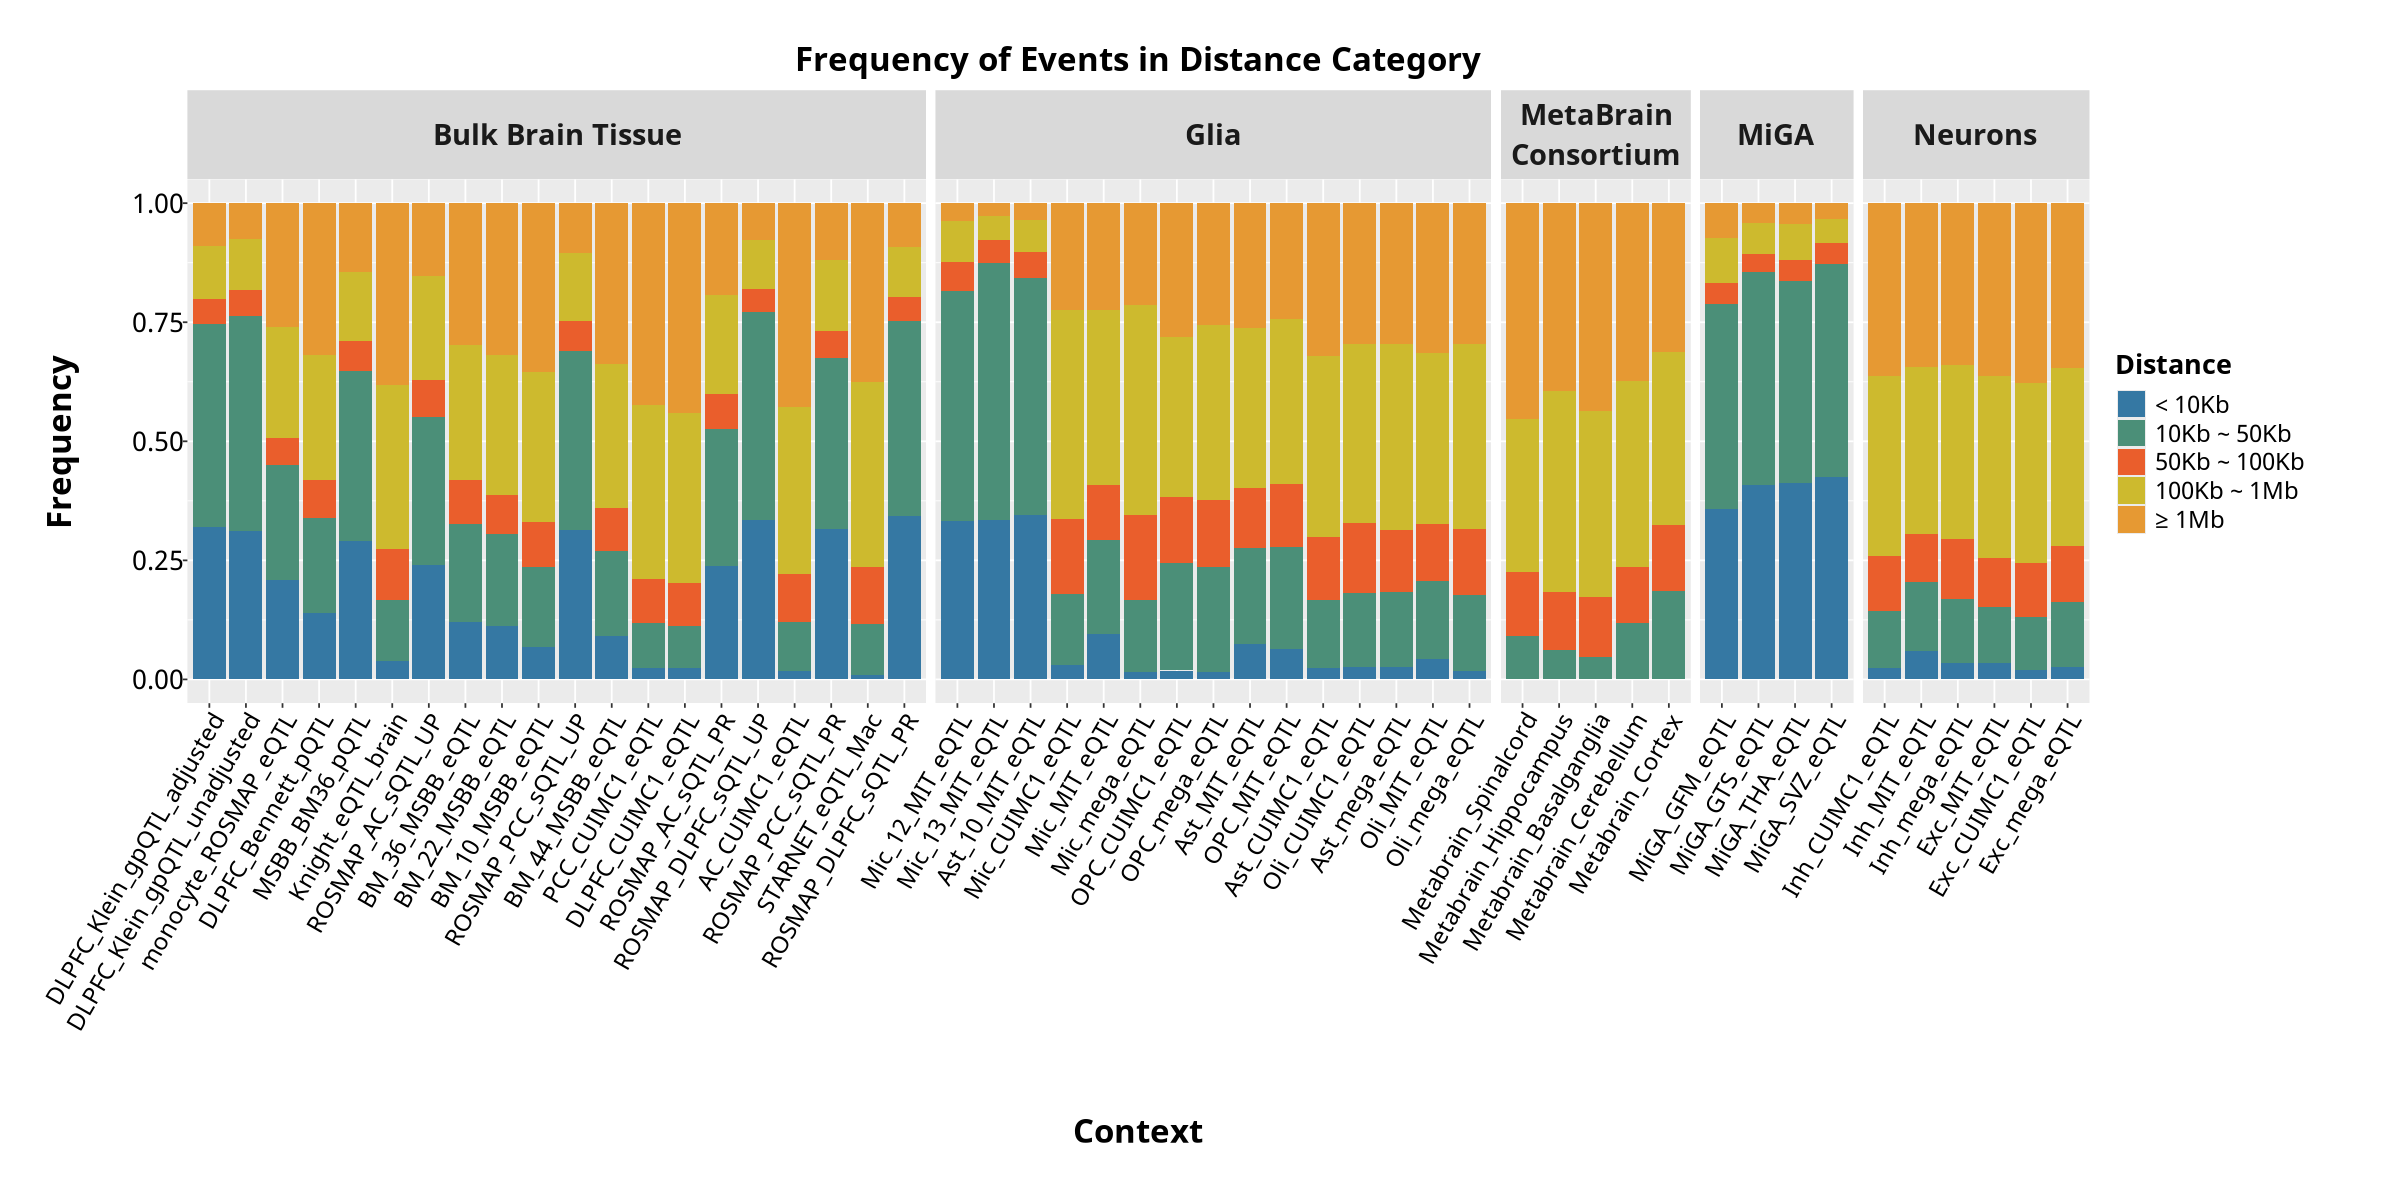

In [15]:
options(repr.plot.width = 20, repr.plot.height = 10)
p1

### Polish Version

In [16]:
color_palette <- c("#FFE1A0", "#FFBE91", "#FF999B", "#FF7AB8", "#DF6FDE")

In [17]:
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("_", " ", singlecontext_top_loci_table_integrated_distance_filtered_category$resource)
head(singlecontext_top_loci_table_integrated_distance_filtered_category)

singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("Kellis", "MIT", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("DeJager", "CUIMC1", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# Fix all patterns to be Cohort Context Modality format:

# 1. STARNET - change "STARNET eQTL Mac" to "STARNET Mac eQTL"
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("STARNET eQTL Mac", "STARNET Mac eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 2. MSBB eQTL - change "BM 44 MSBB eQTL" to "MSBB BM44 eQTL" etc.
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("BM (\\d+) MSBB eQTL", "MSBB BM\\1 eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 3. MSBB pQTL - change "MSBB BM36 pQTL" to "MSBB BM36 pQTL" (already correct)

# 4. Bennett pQTL - change "DLPFC Bennett pQTL" to "Bennett DLPFC pQTL"
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("DLPFC Bennett pQTL", "Bennett DLPFC pQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 5. Klein gpQTL - change "DLPFC Klein gpQTL" to "Klein DLPFC gpQTL"
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("DLPFC Klein (gpQTL adjusted|gpQTL unadjusted)", "Klein DLPFC \\1", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 6. monocyte - change "monocyte ROSMAP eQTL" to "ROSMAP monocyte eQTL"
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("monocyte ROSMAP eQTL", "ROSMAP monocyte eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 7. Knight pQTL - change "Knight pQTL brain" to "Knight brain pQTL"
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("Knight (eQTL|pQTL) brain", "Knight brain \\1", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

# 8. CUIMC1 cell types - change "Ast CUIMC1 eQTL" to "CUIMC1 Ast eQTL" etc.
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("(Ast|Oli|Mic|OPC|Exc|Inh|AC|PCC|DLPFC) CUIMC1 eQTL", "CUIMC1 \\1 eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("(Ast|Oli|Mic|OPC|Exc|Inh) MIT eQTL", "MIT \\1 eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("(Ast|Mic) (\\d+) MIT eQTL", "MIT \\1\\2 eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)
# Change "Ast mega eQTL" to "mega Ast eQTL" etc.
singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource <- gsub("(Ast|Oli|Mic|OPC|Exc|Inh) mega eQTL", "mega \\1 eQTL", singlecontext_top_loci_table_integrated_distance_filtered_category$display_resource)

resource,distance_category,count,frequency,context,tissue_group,total_count,rank_in_group,display_resource
<chr>,<fct>,<int>,<dbl>,<fct>,<chr>,<int>,<int>,<chr>
ROSMAP_DLPFC_sQTL_PR,<10Kb,1499,0.09127999,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1,ROSMAP DLPFC sQTL PR
ROSMAP_DLPFC_sQTL_PR,10Kb~50Kb,1751,0.10662526,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1,ROSMAP DLPFC sQTL PR
ROSMAP_DLPFC_sQTL_PR,50Kb~100Kb,796,0.04847156,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1,ROSMAP DLPFC sQTL PR
ROSMAP_DLPFC_sQTL_PR,100Kb~1Mb,6732,0.40993789,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1,ROSMAP DLPFC sQTL PR
ROSMAP_DLPFC_sQTL_PR,>1Mb,5644,0.34368530,ROSMAP_DLPFC_sQTL_PR,Bulk Brain Tissue,16422,1,ROSMAP DLPFC sQTL PR
STARNET_eQTL_Mac,<10Kb,4320,0.37643778,STARNET_eQTL_Mac,Bulk Brain Tissue,11476,2,STARNET eQTL Mac


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


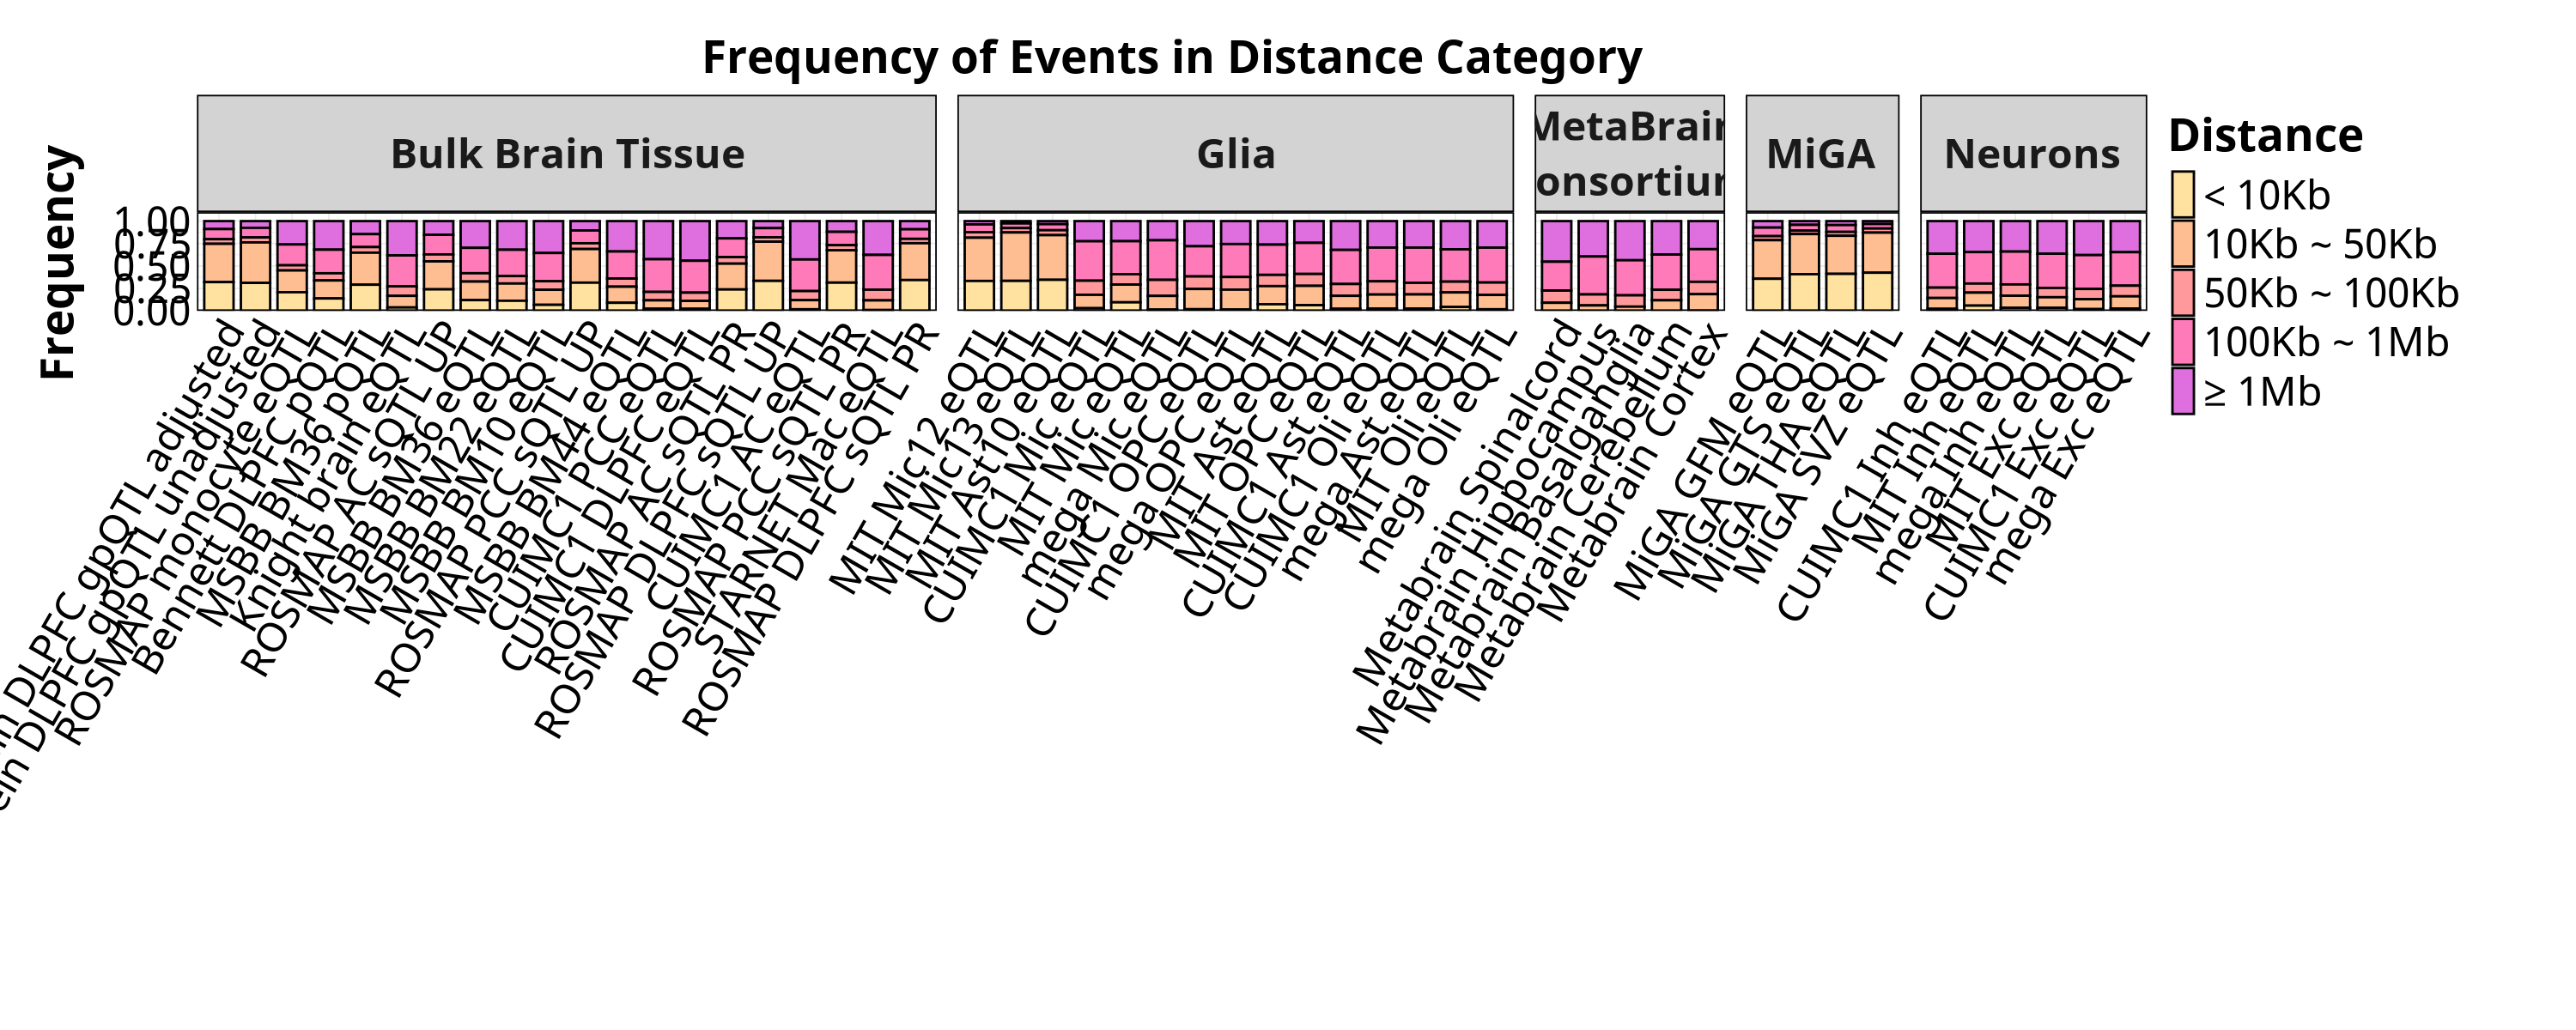

In [18]:
options(repr.plot.width = 25, repr.plot.height = 10)
p1 <- ggplot(singlecontext_top_loci_table_integrated_distance_filtered_category, 
             aes(x = reorder(display_resource, -rank_in_group), y = frequency, fill = distance_category)) +
  geom_bar(stat = "identity", position = "stack", color = "black", linewidth = 0.8, width = 0.8) +  # Increased width for closer bars
  # Add total count labels on top of bars
  #geom_text(aes(label = total_count, y = 1.02), 
  #          vjust = 0, size = 5, fontface = "bold", color = "black") +
  scale_fill_manual(
    values = rev(color_palette), 
    name = "Distance", 
    labels = rev(c("< 10Kb", "10Kb ~ 50Kb", "50Kb ~ 100Kb", "100Kb ~ 1Mb", "≥ 1Mb")),
    guide = guide_legend(reverse = TRUE)
  ) + 
  labs(
    title = "Frequency of Events in Distance Category",
    x = "Context",
    y = "Frequency"
  ) +
  facet_grid(~ tissue_group, scales = "free_x", space = "free_x") +
  theme_minimal(base_family = "Noto Sans") +
  theme(
    axis.text.x = element_text(angle = 60, hjust = 1, size = 36, color = "black"),
    plot.title = element_text(hjust = 0.5, size = 40, face = "bold"),
    axis.title.y = element_text(size = 40, face = "bold", color = "black"),
    axis.title.x = element_blank(),
    axis.text.y = element_text(size = 36, margin = margin(l = 20), color = "black"),
    legend.title = element_text(size = 40, face = "bold"),
    legend.text = element_text(size = 36),
    strip.text = element_text(size = 36, face = "bold"),
    plot.margin = margin(1, 1, 1, 1, "cm"),
    # Adjust facet spacing - reduce space between bars in same group
    panel.spacing = unit(1, "lines"),  # Increased space between facets
    panel.border = element_rect(color = "black", fill = NA, size = 1),
    strip.background = element_rect(color = "black", fill = "lightgray", size = 1)
  ) +
  # Expand y-axis to make room for total count labels
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))

print(p1)
ggsave("Figure_S2.png", p1, width = 16, height = 6, dpi = 300)